Author: Sayantan Mitra <br>
Chief Data Scientist, Compton & Wendler<br>
Ph.D. candidate, Baylor College of Medicine

In [1]:
import numpy as np
import pandas as pd
from collections import Counter

# VisualiZation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

### Goal 1: Predict size of solar panels of unseen data based on RIDGE regression model saved in notebook 2

In [2]:
new_data = pd.read_csv('new_data.csv', usecols=['state', 'size_kw', 'zipcode', 'installer', 'city', 
                                                'tech_1', 'county', 'annual_PV_prod', 'year'])
new_data.head()

,state,size_kw,zipcode,installer,city,tech_1,county,annual_PV_prod,year
0,CA,4.675,91915,Rec Solar,CHULA VISTA,Poly,San Diego,7195.092078,2015
1,CA,4.050,93021,Advanced Solar Electric,Moorpark,Mono,Ventura,5890.233582,2009
2,CA,10.080,95608,Sierra Pacific Home & Comfort,Carmichael,Poly,Sacramento,14574.754690,2012
3,NY,5.750,11795,NaN,West Islip,Poly,Suffolk,7537.072205,2015
4,CA,3.750,93444,SolarCity,Nipomo,Poly,San Luis Obispo,6262.514191,2014


In [3]:
solar_train = pd.read_csv('solar_train.csv')
# Extract 1st number of zipcode
new_data['zipcode_1'] = new_data['zipcode'].astype('str').str[:1].astype(int)
# year as a categorical column to take care of cardinality
solar_train['year'] = solar_train['year'].astype('str')
new_data['year'] = new_data['year'].astype('str')

def group_levels_in_categoricals(df, threshold=0.01, min_freq=0, max_freq=np.Inf):
    df0 = df.describe(include=['O']).T
    # reduced list is name of categorical columns
    reduced_list = df0[(df0.unique < max_freq) & (df0.unique > min_freq)].reset_index()['index'].tolist()
    
    #patterns will contain list of all categories of all categorical column whose occurance is more than threshold
    patterns = []
    other = []
    for col in reduced_list:
        df_normalized = df[col].value_counts(normalize=True).reset_index()
        df_normalized.columns = ['col_name', 'normalized_value']
        filt = df_normalized['normalized_value'] > threshold
        # norm_list contains all the categories in a categorical column whose occurance is more than threshold    
        norm_list = df_normalized[filt]['col_name'].tolist()
        pattern = norm_list
        patterns.append(norm_list)
        # selecting categories that are present less than threshold
        others_list = df_normalized[~filt]['col_name'].tolist()
        other.append(others_list)
        
        if pattern != []: 
            df[col] = df[col].replace({x:'Other' for x in others_list})
        else:
            df.drop(col, inplace=True, axis=1)
    return (df, patterns, reduced_list, other)
df, patterns, reduced_list, other = group_levels_in_categoricals(solar_train)

# We have to keep this consistent with test data as well
def group_levels_in_categoricals_test(reduced_list, other, patterns, df_test):   
    for idx, col in enumerate(reduced_list):       
        if other[idx] != []:
            filt = df_test[col].isin(patterns[idx])
            df_test[col][~filt]='Others'
        else:
            df_test.drop(col, inplace=True, axis=1)       
    return df_test
new_data = group_levels_in_categoricals_test(reduced_list, other, patterns, new_data)

**Data Preparation**

In [4]:
# Feature engineering like train set in Notebook 2
solar_train['size_kw_L'] = np.log1p(solar_train['size_kw'])
new_data['size_kw_L'] = np.log1p(new_data['size_kw'])

solar_train['annual_PV_prod_L'] = np.log1p(solar_train['annual_PV_prod'])
new_data['annual_PV_prod_L'] = np.log1p(new_data['annual_PV_prod'])

solar_train['annual_PV_prod_L-s2'] = solar_train['annual_PV_prod_L']** 2
new_data['annual_PV_prod_L-s2'] = new_data['annual_PV_prod_L']** 2

solar_train['zipcode_1'] = solar_train['zipcode_1'].apply(str)
new_data['zipcode_1'] = new_data['zipcode_1'].apply(str)

# Categorical encoding
solar_train = pd.get_dummies(solar_train)
new_data = pd.get_dummies(new_data)

# Dependent variable
new_data_real_size = new_data['size_kw']
y = new_data[['size_kw_L']]
y1 = new_data['size_kw_L']

# Independent variables
solar_train = solar_train.drop(columns=['size_kw', 'size_kw_L', 'zipcode', 'annual_PV_prod', 'annual_PV_prod_L'])                         
new_data = new_data.drop(columns=['size_kw', 'size_kw_L', 'zipcode', 'annual_PV_prod', 'annual_PV_prod_L']) 

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
solar_train_stndz = sc.fit_transform(solar_train)
new_data_stndz = sc.transform(new_data)

### Testing the ridge model on unseen data

In [5]:
from sklearn.externals import joblib
rg1 =joblib.load('size_prediction_model.joblib')
print(f'Saved ridge_model_r2 with new_data: {rg1.score(new_data_stndz, y).round(4)}')

Saved ridge_model_r2 with new_data: 0.9644


**Plotting predicted and actual size of solar panels**

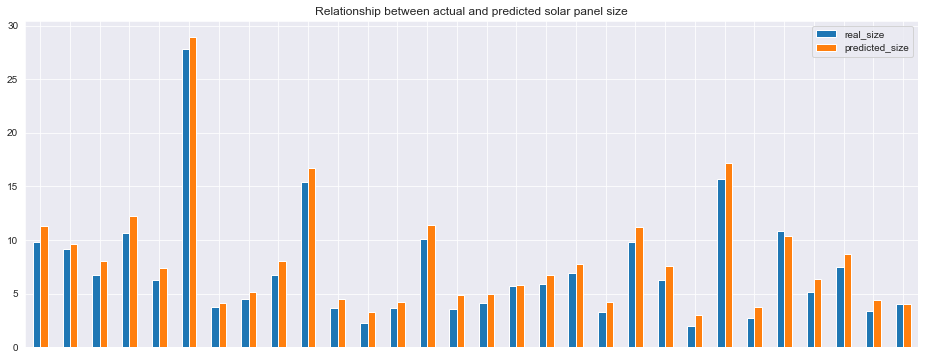

In [6]:
# Relationship between actual solar panel and predicted solar panel size (transformed)
fig, axes = plt.subplots(1,1, figsize = (16,6))
y_pred_actual = np.exp(rg1.predict(new_data_stndz))
size_pred = pd.DataFrame({'real_size':new_data_real_size, 'predicted_size':y_pred_actual})
size_pred.sample(n=30).plot(kind='bar', ax=axes)
axes.set_title('Relationship between actual and predicted solar panel size')
axes.set_xticklabels('');

■ Prediction on real size of solar panels of unseen data is pretty accurate.

### Goal 2: Predicting size of solar panel for an individual based on energy consumption<br>
After getting electric bill for summer, Uncle Bob decides to opt for solar energy. He checks his power consumption and provides his details:<br>
state= California (CA), installer=SolarCity, city=Nipomo, tech_1=Poly, county=San Luis Obispo, annual power consumption=6262.51, zipcode first number=9

In [7]:
uncle_bob  =pd.DataFrame({'state': 'CA', 'zipcode':93444, 'installer':'SolarCity', 
                          'city':'Nipomo', 'tech_1': 'Poly', 'county':'San Luis Obispo', 
                          'annual_PV_prod': 6262.51, 'year':'2014'}, index=[0])
# Extract 1st number of zipciode
uncle_bob['zipcode_1'] = uncle_bob['zipcode'].astype('str').str[:1].astype(int)
uncle_bob

,state,zipcode,installer,city,tech_1,county,annual_PV_prod,year,zipcode_1
0,CA,93444,SolarCity,Nipomo,Poly,San Luis Obispo,6262.51,2014,9


**Data preparation**

In [8]:
new_data = pd.read_csv('new_data.csv')
new_data = pd.read_csv('new_data.csv', usecols=['state','zipcode','installer', 'city', 'tech_1', 
                                                'size_kw', 'county', 'annual_PV_prod', 'year', 'zipcode_1'])
uncle_bob_test = new_data.append(uncle_bob, ignore_index=True)
uncle_bob_test['year'] = uncle_bob_test['year'].astype('str')
solar_train = pd.read_csv('solar_train.csv')
solar_train['year'] = solar_train['year'].astype('str')

# cardinality
df, patterns, reduced_list, other = group_levels_in_categoricals(solar_train)
uncle_bob_test  = group_levels_in_categoricals_test(reduced_list, other, patterns, uncle_bob_test)
# Align columns
uncle_bob_test = uncle_bob_test[solar_train.columns]

# Feature engineering like train set in Notebook 2
solar_train['size_kw_L'] = np.log1p(solar_train['size_kw'])
uncle_bob_test['size_kw_L'] = np.log1p(uncle_bob_test['size_kw'])
uncle_bob_test['annual_PV_prod_L'] = np.log1p(uncle_bob_test['annual_PV_prod'])
solar_train['annual_PV_prod_L'] = np.log1p(solar_train['annual_PV_prod'])
uncle_bob_test['annual_PV_prod_L-s2'] = uncle_bob_test['annual_PV_prod_L']** 2
solar_train['annual_PV_prod_L-s2'] = solar_train['annual_PV_prod_L']** 2
uncle_bob_test['zipcode_1'] = uncle_bob_test['zipcode_1'].apply(str)
solar_train['zipcode_1'] = solar_train['zipcode_1'].apply(str)

# Categorical encoding
solar_train = pd.get_dummies(solar_train)
uncle_bob_test1 = pd.get_dummies(uncle_bob_test)
solar_train.shape, uncle_bob_test1.shape

# actual size of solar panels
y = uncle_bob_test1['size_kw']
y_new_data = y[:-1]

# Drop columns
uncle_bob_test1 = uncle_bob_test1.drop(columns=[ 'size_kw', 'size_kw_L', 'zipcode', 'annual_PV_prod', 'annual_PV_prod_L']) 
solar_train = solar_train.drop(columns=[ 'size_kw', 'size_kw_L', 'zipcode', 'annual_PV_prod', 'annual_PV_prod_L']) 
solar_train.shape, uncle_bob_test1.shape

# Scale data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
solar_train_stndz = sc.fit_transform(solar_train)
uncle_bob_stndz = sc.transform(uncle_bob_test1)

### Predicting size of the solar panel uncle Bob need to install based on  power consumption !

In [9]:
uncle_bob_pred = np.exp(rg1.predict(uncle_bob_stndz))
size_array = pd.DataFrame(uncle_bob_pred)
df = pd.concat([uncle_bob_test, size_array], axis=1)
df.rename(columns={0: 'predicted_size'}, inplace=True)
df.iloc[[-1],[7,-1]]

,annual_PV_prod,predicted_size
97451,6262.51,5.325729


Uncle bob needs to install solar panel of 5.3kw to replace total annual traditional energy consumption of 6262.51kwh.